In [1]:
from mss import mss
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
from tensorflow.keras.utils import to_categorical
from PIL import Image
#import pyautogui
import keyboard
import mouse
import pytesseract
from time import sleep
import winsound
from re import sub

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

In [3]:
class Dataset(torch.utils.data.Dataset):
    '''
    Generates input maps and commands for Hakisa.

    Remember: command_types = list of strings, actions1 and 2 = list of strings(keyboard), X coordinates or None(mouse)
    '''
    
    def __init__(
        self,
        command_types = None,
        actions1 = None,
        actions2 = None,
        explore_train_steps=1000,
        memory_size=100,
        top=0,
        left=0,
        width=1920,
        height=1080,
        resize=None
    ):

        # Window resolutions for the screen grabber
        self.top = top
        self.left = left
        self.width = width
        self.height = height

        self.resize = resize # For reducing the images. Must be a tuple (Height, Width)

        self.steps = explore_train_steps

        self.data = None # This will be created during training. However, it's possible to load a ready-made data for training.

        # Initially, we'll be using lists. After our vector embedding has been properly trained, we'll create a dictionary
        # of input mappings with it -----> Here, we won't be doing this as we'll actually be testing the softmax and a more traditional approach.

        self.command_type = command_types
        self.actions1 = actions1
        self.actions2 = actions2

        self.encoded_command_type = self._encode(self.command_type)
        self.encoded_actions1 = self._encode(self.actions1)
        self.encoded_actions2 = self._encode(self.actions2)

        self.labels = None # Used for studying
        self.rewards = None # Also used for studying.

        self.memory_size = memory_size
        self.memory = []


    # Pytorch's Dataset functions will only be used in Studying mode
    def __getitem__(self, idx):

        inputs = self.data[idx]
        return inputs


    def __len__(self):

        return len(self.data)


    def _grab_frame(self):
        # Unfortunately, this whole operation takes about 0.6 seconds, so we'll probably have to deal with a single frame each 1~3 seconds.
        with mss() as sct:
            frame = sct.grab(monitor={"top": self.top, "left": self.left, "width": self.width, "height": self.height})
            frame = Image.frombytes("RGB", frame.size, frame.bgra, 'raw', 'BGRX')

            if self.resize:
                frame = frame.resize(self.resize)

            frame = np.array(frame, dtype=np.float32)

            frame = torch.from_numpy(frame)
        
        frame = frame.view(1, frame.size(2), frame.size(0), frame.size(1)).to(device) # (Batch, Channels, Height, Width)

        return frame

    def _encode(self, command_list):

        encoded_command = to_categorical(np.arange(0, len(command_list)), len(command_list))
        encoded_command = torch.from_numpy(encoded_command)

        return encoded_command


    def get_command(self, cmd_type, action1, action2, exploration=False):
        '''
        Hakisa's output: (command_type, action1, action2) ----> (key, Down, z) or (click, 100, 60)
        command_type, action1 and action2 are the argmax output from a logsoftmax function and will be used as index for their respectives lists.
        '''

        cmd_type = self.command_type[cmd_type]
        action1 = self.actions1[action1]
        action2 = self.actions2[action2]

        command = (cmd_type, action1, action2)

        del cmd_type, action1, action2

        return command

    def get_consequences(self, top, left, width, height, togray=False, threshold=False, thresh_gauss=171, thresh_C=13, tesseract_config='--psm 8'):
        '''
        Used after Hakisa performed an input, in order to get its consequences(ex: score change, bombs, kills, deaths...).
        Returns a string according to Tesseract's OCR.
        '''

        with mss() as sct:
            consequence = sct.grab(monitor={"top": top, "left": left, "width": width, "height": height})

            consequence = Image.frombytes("RGB", consequence.size, consequence.bgra, 'raw', 'BGRX')

        if togray is True:

            consequence = consequence.convert("P") # Sometimes, simply converting to grayscale is enough

            if threshold is True:
                if "ADAPTIVE_THRESH_GAUSSIAN_C" and "adaptiveThreshold" and "THRESH_BINARY" not in dir():
                    from cv2 import adaptiveThreshold, ADAPTIVE_THRESH_GAUSSIAN_C, THRESH_BINARY

                consequence = adaptiveThreshold(np.array(consequence),255,ADAPTIVE_THRESH_GAUSSIAN_C, THRESH_BINARY,thresh_gauss,thresh_C)
                consequence = Image.fromarray(consequence)
        
        consequence = pytesseract.image_to_string(consequence, config=tesseract_config) 

        # OCR adds some strange characters(even with the whitelist function). Let's remove them.

        consequence = sub('[^A-Za-z0-9/.]', '', consequence) # Attention: 0, 1 and 8 can be seen as O, l and B.

        return consequence

    def create_memory(self, frame, keys, values, reward):
        '''
        Saves data in the memory list.
        Memory is saved in the format (frame, (command_type, action1_key, action2_key), (command_index, action1_value, action2_value), reward)

        During study mode, frame will be used as input during training. The tuple of values and reward, as labels.
        The tuple of keys is used for visualization, and reward also works as weights(helps discarding bad decisions and saving good ones).
        
        Use cumulative rewards.

        Memory will only be changed once it reaches its full size.
        '''

        reward = reward # Beta can be a constant value, like 1e-5. This just to avoid big numbers.


        memory = (frame, keys, values, reward) # A tuple makes each item in the list iterable...and its easier to visualize than lists of lists.


        if len(self.memory) < self.memory_size:

            self.memory.append(memory)
        
        else:
            self.memory = sorted(self.memory, key=lambda x: x[3]) # Sorting list according to rewards values.
            self.memory.pop(0) # Removing the item with lowest reward value
            
            self.memory.append(memory)
        
        del memory

    def create_data_for_study(self):

        # Creating dataset for studying

        inputs = [i[0].cpu() for i in self.memory] # game frames. Using cpu to avoid CudaMemory errors.
        labels = [i[2] for i in self.memory] # (command_type index, action1 value, action2 value)
        actions1 = [i[1][1] for i in self.memory] # action1 key for one-hot encoding
        actions2 = [i[1][2] for i in self.memory] # action2 key
        rewards = [i[3] for i in self.memory] # Reward got in that step.

        inputs = torch.cat(inputs, 0)

        labels = np.stack(labels, 0).astype(np.float32) # Now converting to float here to avoid numpy.dtype == object
        encoded_actions1 = to_categorical(np.arange(0, len(actions1)), len(self.actions1))
        encoded_actions2 = to_categorical(np.arange(0, len(actions2)), len(self.actions2))
        rewards = np.stack(rewards, 0).astype(np.float32)

        labels = torch.from_numpy(labels)
        encoded_actions1 = torch.from_numpy(encoded_actions1)
        encoded_actions2 = torch.from_numpy(encoded_actions2)
        rewards = torch.from_numpy(rewards)

        self.data = inputs
        self.labels = labels.to(device)
        self.encoded_actions1 = encoded_actions1.to(device)
        self.encoded_actions2 = encoded_actions2.to(device)
        self.rewards = rewards.to(device)

        del inputs, labels, rewards

    def record_gameplay(self, number_of_screenshots, screenshot_delay, grayscale=False, resize=False, path=None):

        # Resizing and grayscaling isn't really necessary here, but can save you some time later.
        # Both saving you from writing more code and from making your hardware having to process more and more data at once.

        print(f"Ok. Screenshot capture will begin in 5 seconds")

        sleep(5)

        winsound.PlaySound('D:/Python/Audio/English/chiara_hacking_1_en.wav', winsound.SND_FILENAME) # Just to know if everything's ok

        for i in range(number_of_screenshots):

            with mss() as sct:

                frame = sct.grab(monitor={"top": self.top, "left": self.left, "width": self.width, "height": self.height})
                frame = Image.frombytes("RGB", frame.size, frame.bgra, 'raw', 'BGRX')

            if grayscale:

                frame = frame.convert('L')

            if resize:

                frame = frame.resize(self.resize)

            frame.save(f"{path}/{i+2000}.png")

            sleep(screenshot_delay)
        
        print("Screenshot capture finished!")

        winsound.PlaySound('D:/Python/Audio/English/chiara_hacking_1_en.wav', winsound.SND_FILENAME)

    def save_memory(self, memory_name):

        import pickle

        with open(f'Hakisa_memory_{memory_name}.pkl', 'wb') as f:
            pickle.dump(self.memory, f)
        
        print(f"Memory saved! You can load it again with")
        print(f"open('Hakisa_memory_{memory_name}.pkl', 'rb') as f:\n\tdataset.memory = pickle.load(f)")
        print("Don't forget to close the file!")

        f.close()

In [4]:
class Hakisa(torch.nn.Module):
    '''
    Hakisa itself.

    She has 2 ways of acting, according to her current mode:

        if mode = 'Explore', her inputs can be None, and will generate a random integer according to the input mapping, playing randomly.

        if mode = 'Study', she'll receive game frames as inputs, extract the most relevant features and,
        in the end, will generate 2 outputs:

            output 1: a tuple of commands (command_type, action1, action2). Sizes (Batch, 1)
            output 2: prediction of the reward to be obtained through that action. Size (Batch, 1)

        if mode = 'Play', she'll receive game frames, previous commands, previous reward and previous action quality, generating:

            output 1: a tuple of commands (command_type, action1, action2). Sizes (Batch, 1)
            output 2: prediction of the reward to be obtained through that action. Size (Batch, 1)
            output 3: a prediction of how good her action was(0 = bad, 1 = ok, 2 = good).
    '''

    def __init__(self, command_types, actions1, action1_dims, actions2, action2_dims, mode='Explore'):

        super(Hakisa, self).__init__()

        self.mode = mode

        self.command_types = command_types
        self.actions1 = actions1
        self.action1_dims = action1_dims # How many dimensions the embedding matrix will have
        self.actions2 = actions2
        self.action2_dims = action2_dims

        # This structure must be changed with the input size...unless you'd like to use adaptive pooling

        # Let's begin supposing that we're gonna use 200x200 RGB images ---> (3, 200, 200)

        # 200x200

        self.conv1 = torch.nn.Conv2d(3, 100, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm1 = torch.nn.BatchNorm2d(100)
        self.conv2 = torch.nn.Conv2d(100, 100, kernel_size=3, stride=1, padding=1, bias=False) # 200x200
        self.batchnorm2 = torch.nn.BatchNorm2d(100)
        self.pool2x2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # 100x100
        self.conv3 = torch.nn.Conv2d(100, 200, kernel_size=3, stride=1, padding=1, bias=False) # 100x100
        self.batchnorm3 = torch.nn.BatchNorm2d(200)
        self.conv4 = torch.nn.Conv2d(200, 400, kernel_size=3, stride=1, padding=1, bias=False) # 100x100
        self.batchnorm4 = torch.nn.BatchNorm2d(400)
        # Add pool 2x2 ---> 50x50
        self.conv5 = torch.nn.Conv2d(400, 800, kernel_size=3, stride=1, padding=1, bias=False) # 50x50
        self.batchnorm5 = torch.nn.BatchNorm2d(800)
        self.conv6 = torch.nn.Conv2d(800, 1000, kernel_size=3, stride=1, padding=1, bias=False) # 50x50
        self.batchnorm6 = torch.nn.BatchNorm2d(1000)
        # Add pool 2x2 ---> 25x25
        self.conv7 = torch.nn.Conv2d(1000, 1000, kernel_size=4, stride=1, bias=False) # 22x22
        self.batchnorm7 = torch.nn.BatchNorm2d(1000)
        self.conv8 = torch.nn.Conv2d(1000, 1000, kernel_size=3, stride=1, bias=False) # 20x20
        self.batchnorm8 = torch.nn.BatchNorm2d(1000)
        # Add pool 2x2 ---> 10x10
        self.conv9 = torch.nn.Conv2d(1000, 800, kernel_size=3, stride=1, padding=1, bias=False) # 10x10
        self.batchnorm9 = torch.nn.BatchNorm2d(800)
        self.conv10 = torch.nn.Conv2d(800, 400, kernel_size=3, stride=1, padding=1, bias=False) # 10x10
        self.batchnorm10 = torch.nn.BatchNorm2d(400)
        # Add pool 2x2 ---> 5x5
        self.neuron1 = torch.nn.Linear(400*5*5, 200*2*2, bias=False)
        self.layer_norm1 = torch.nn.LayerNorm(200*2*2)

        if len(self.command_types) > 1:

            self.embed_command_type = torch.nn.Embedding(len(self.command_types), len(self.command_types)) # To be concatenated to features extracted from state

            self.neuron_command_study = torch.nn.Linear(200*2*2, len(self.command_types), bias=False)
            self.neuron_command_play = torch.nn.Linear(1200, len(self.command_types), bias=False)

            # Considering the command_type that has been predicted, what should be the action1 and action2?

            self.neuron2 = torch.nn.Linear(len(self.command_types), 100*2*2, bias=False)

        else:
        
            self.neuron2_study = torch.nn.Linear(200*2*2, 100*2*2, bias=False)
            self.neuron2_play = torch.nn.Linear(1200, 100*2*2, bias=False)

        self.neuron_quality = torch.nn.Linear(1, 200, bias=False)

        self.layer_norm2 = torch.nn.LayerNorm(100*2*2)

        self.embed_action1 = torch.nn.Embedding(len(self.actions1), self.action1_dims)
        self.neuron_action1A = torch.nn.Linear(len(self.actions1)*self.action1_dims, 100*2*2, bias=False) # To be concatenated with neuron 2
        self.neuron_action1B = torch.nn.Linear(100*2*2*2, len(self.actions1), bias=False) # Apply softmax

        self.embed_action2 = torch.nn.Embedding(len(self.actions2), self.action2_dims)
        self.neuron_action2A = torch.nn.Linear(len(self.actions2)*self.action2_dims, 100*2*2, bias=False) # To be concatenated with neuron 2
        self.neuron_action2B = torch.nn.Linear(100*2*2*2, len(self.actions2), bias=False)

        self.neuron_reward = torch.nn.Linear(1, 200, bias=False)
        self.layer_normcat = torch.nn.LayerNorm(1200)
        self.neuron_predquality = torch.nn.Linear(len(self.command_types)+len(self.actions1)+len(self.actions2), 3, bias=False)
        self.neuron_predreward1 = torch.nn.Linear(len(self.command_types)+len(self.actions1)+len(self.actions2), 1000, bias=False)
        self.neuron_predreward2 = torch.nn.Linear(1000, 1, bias=False)

        self.PRelu = torch.nn.PReLU(1)

        self.softmax = torch.nn.LogSoftmax(-1) # Since we're using softmax here, use NLLLoss during study and play mode.
    

    def forward(self, input=None, frame_sequence=None, previous_action=None, previous_reward=None):

        if self.mode == "Explore":
            # Reinventing the wheel didn't work. Now, in exploration mode, Hakisa will simply generate random numbers.
            
            command_type = torch.randint(0, len(self.command_types), size=(1,), device=device)

            # Remember that, in exploration mode, we'll be generating data for our vectorizer model, so we'll be dealing exclusively with
            # integers(indices for our input mapping lists)

            action1 = torch.randint(0, len(self.actions1), size=(1,), device=device)
            action2 = torch.randint(0, len(self.actions2), size=(1,), device=device)
                
            #action1 = torch.normal(0, max(dataset.actions1.values()), size=(1, 1), device=device)
            #action2 = torch.normal(0, max(dataset.actions2.values()), size=(1, 1), device=device)

            return (command_type, action1, action2)


        elif self.mode == 'Study':

            x = self.conv1(input)
            x = self.batchnorm1(x)
            x = self.PRelu(x)
            x = self.conv2(x)
            x = self.batchnorm2(x)
            x = self.PRelu(x)

            x = self.pool2x2(x)

            x = self.conv3(x)
            x = self.batchnorm3(x)
            x = self.PRelu(x)
            x = self.conv4(x)
            x = self.batchnorm4(x)
            x = self.PRelu(x)

            x = self.pool2x2(x)

            x = self.conv5(x)
            x = self.batchnorm5(x)
            x = self.PRelu(x)
            x = self.conv6(x)
            x = self.batchnorm6(x)
            x = self.PRelu(x)

            x = self.pool2x2(x)

            x = self.conv7(x)
            x = self.batchnorm7(x)
            x = self.PRelu(x)
            x = self.conv8(x)
            x = self.batchnorm8(x)
            x = self.PRelu(x)

            x = self.pool2x2(x)

            x = self.conv9(x)
            x = self.batchnorm9(x)
            x = self.PRelu(x)
            x = self.conv10(x)
            x = self.batchnorm10(x)
            x = self.PRelu(x)
            
            x = self.pool2x2(x)

            x = x.view(x.size(0), -1) # (batch, 400*5*5)

            x = self.neuron1(x) # (batch, 200*2*2)
            x = self.layer_norm1(x)
            x = self.PRelu(x)

            if len(self.command_types) > 1:

                vector = self.embed_command_type(torch.arange(len(self.command_types), device=device)) # (Batch, 1, n_commands)
                vector = vector.view(x.size(0), -1) # (batch, n_commands)

                command_type = self.neuron_command_study(x) # (Batch, n_commands)

                command_type = command_type + vector

                del vector

                command_type = self.softmax(command_type) # (Batch, n_commands)

                x = self.neuron2(command_type) # (Batch, 100*2*2)

            else:
                command_type = torch.ones((input.size(0), 1), device=device)

                x = self.neuron2_study(x) # (Batch, 100*2*2)

            x = self.layer_norm2(x)
            x = self.PRelu(x)

            vector = self.embed_action1(torch.arange(len(self.actions1), device=device)) # (Batch, 1, n_action1_dims)
            vector = vector.view(x.size(0), -1) # (Batch, n_action1_dims)
            vector = self.neuron_action1A(vector) # (Batch, 100*2*2)

            vector = torch.cat((x, vector), -1) # (Batch, 100*2*2*2)

            action1 = self.neuron_action1B(vector) # (Batch, len(actions1))

            action1 = self.softmax(action1)

            vector = self.embed_action2(torch.arange(len(self.actions2), device=device)) # (Batch, 1, n_action2_dims)
            vector = vector.view(x.size(0), -1) # (Batch, n_action2_dims)
            vector = self.neuron_action2A(vector) # (Batch, 100*2*2)

            vector = torch.cat((x, vector), -1) # (Batch, 100*2*2*2)

            action2 = self.neuron_action2B(vector) # (Batch, 1)

            action2 = self.softmax(action2)

            del vector

            x = torch.cat((command_type.detach(), action1.detach(), action2.detach()), 1) # (Batch, len(command_type) + len(action1) + len(action2))
            # Using .detach() for concatenation to prevent reward prediction backpropagation from interferring on actions prediction

            x = self.neuron_predreward1(x)
            predicted_reward = self.neuron_predreward2(x)

            del x

            return (command_type, action1, action2), predicted_reward

        else:

            x = self.conv1(input)
            x = self.batchnorm1(x)
            x = self.PRelu(x)
            x = self.conv2(x)
            x = self.batchnorm2(x)
            x = self.PRelu(x)

            x = self.pool2x2(x)

            x = self.conv3(x)
            x = self.batchnorm3(x)
            x = self.PRelu(x)
            x = self.conv4(x)
            x = self.batchnorm4(x)
            x = self.PRelu(x)

            x = self.pool2x2(x)

            x = self.conv5(x)
            x = self.batchnorm5(x)
            x = self.PRelu(x)
            x = self.conv6(x)
            x = self.batchnorm6(x)
            x = self.PRelu(x)

            x = self.pool2x2(x)

            x = self.conv7(x)
            x = self.batchnorm7(x)
            x = self.PRelu(x)
            x = self.conv8(x)
            x = self.batchnorm8(x)
            x = self.PRelu(x)

            x = self.pool2x2(x)

            x = self.conv9(x)
            x = self.batchnorm9(x)
            x = self.PRelu(x)
            x = self.conv10(x)
            x = self.batchnorm10(x)
            x = self.PRelu(x)
            
            x = self.pool2x2(x)

            x = x.view(x.size(0), -1) # (batch, 400*5*5)

            x = self.neuron1(x) # (batch, 200*2*2)

            if previous_action==None and previous_reward==None: # For first iteration

                previous_action = (torch.zeros((1), device=device), torch.zeros(1, device=device), torch.zeros(1, device=device))
                previous_reward = torch.zeros((input.size(0), 1), device=device)

            a, b, c = previous_action

            previous_action = a + b + c

            del a, b, c

            previous_action = previous_action.unsqueeze(0)

            previous_action = self.neuron_quality(previous_action) # (batch, 200)
            previous_reward = self.neuron_reward(previous_reward) # (batch, 200)

            x = torch.cat((x, previous_action, previous_reward), 1) # (batch, 1200)

            x = self.layer_normcat(x)
            x = self.PRelu(x)

            if len(self.command_types) > 1:

                vector = self.embed_command_type(torch.arange(len(self.command_types), device=device)) # (Batch, 1, n_commands)
                vector = vector.view(x.size(0), -1) # (batch, n_commands)

                command_type = self.neuron_command_play(x)
                command_type = command_type + vector

                del vector

                command_type = self.softmax(command_type) # (Batch, n_commands)

                x = self.neuron2(command_type)

            else:
                command_type = torch.zeros((input.size(0), 1), device=device)

                x = self.neuron2_play(x) # (Batch, 100*2*2)

            x = self.layer_norm2(x)
            x = self.PRelu(x)

            vector = self.embed_action1(torch.arange(len(self.actions1), device=device)) # (Batch, 1, n_action1_dims)
            vector = vector.view(x.size(0), -1) # (Batch, n_action1_dims)
            vector = self.neuron_action1A(vector) # (Batch, 100*2*2)

            vector = torch.cat((x, vector), -1) # (Batch, 100*2*2*2)

            action1 = self.neuron_action1B(vector) # (Batch, len(actions1))

            action1 = self.softmax(action1) # Since each action here have size (1, len(actions1)), access each action with actions1[torch.argmax(action1, -1)]

            vector = self.embed_action2(torch.arange(len(self.actions2), device=device)) # (Batch, 1, n_action2_dims)
            vector = vector.view(x.size(0), -1) # (Batch, n_action2_dims)
            vector = self.neuron_action2A(vector) # (Batch, 100*2*2)

            vector = torch.cat((x, vector), -1) # (Batch, 100*2*2*2)

            action2 = self.neuron_action2B(vector) # (Batch, 1)

            action2 = self.softmax(action2)

            del vector

            x = torch.cat((command_type, action1, action2), 1) # (Batch, len(command_type) + len(action1) + len(action2))

            # Attention: .detach() here causes all the previous layers to be excluded from backpropagation.
            # This happens because the backpropagation is based on predicted_reward only.

            command_quality = self.neuron_predquality(x) # (Batch, 3)
            command_quality = self.softmax(command_quality)

            x = self.neuron_predreward1(x)
            predicted_reward = self.neuron_predreward2(x)

            del x

            return (command_type, action1, action2), command_quality, predicted_reward


    def execute_command(self, command):
        '''
        Command must be a tuple(command_type, action1, action2), where:

            command_type: key(keyboard) or move, rightClick, click(mouse)
            action1: Up, Down, press(keyboard), X coordinate(mouse) or None(no mouse movement)
            action2: 'a', 'z', 'shift'...(keyboard), Y coordinate(mouse) or None(no mouse movement)

        Make sure all key actions(action2) are lowered.

        Have in mind that Hakisa might output command_type 'key' and action1 that is equivalent to a mouse action.
        '''

        if "key" in command[0]:

            try:
                
                if "Up" in command[1]:

                    try:
                        #pyautogui.keyUp(command[2])
                        keyboard.release(command[2])
                
                    except:
                        pass # If Hakisa predicts a mouse action for a keyboard command, she won't do anything.

                elif "Down" in command[1]:

                    try:
                        #pyautogui.keyDown(command[2])
                        keyboard.press(command[2])

                    except:
                        pass

                elif "press" in command[1]:

                    try:
                        keyboard.send(command[2]) # Some games won't work with pyautogui.press(), so use keyboard module, since we'll import it for Play Mode.
                    
                    except:
                        pass

                else:
                    pass
            
            except:

                pass # If Hakisa predicts a keyboard command, but outputs a mouse action, she won't do anything.

        elif "move" in command[0]:

            try:
                #pyautogui.moveTo(command[1], command[2], duration=0.19) # Duration = 0.19 seconds to be more realistic
                mouse.move(command[1], command[2], duration=0.1)

            except:
                pass # If Hakisa predict a mouse command, but outputs a keyboard action, she won't do anything.

        elif "rightclick" in command[0]:
            
            try:
                mouse.move(command[1], command[2], duration=0.1)
                mouse.right_click()
            except:
                pass

        elif "click" in command[0]:

            try:
                #pyautogui.moveTo(command[1], command[2], duration=0.19)
                mouse.move(command[1], command[2], duration=0.1)
                mouse.click() # Same case as press. Use mouse module.
            except:
                pass

        else:

            raise ValueError # It was probably you who made a mistake.

In [5]:
# Jigoku Kisetsukan

command_type = ['key']

actions1 = ['Down', 'Up']

actions2 = ['up', 'down', 'left', 'right', 'z', 'x', 'shift']

In [6]:
dataset = Dataset(command_types=command_type, actions1=actions1, actions2=actions2, explore_train_steps=100, memory_size=10, resize=(200, 200))

In [7]:
hakisa = Hakisa(command_types=command_type, actions1=actions1, action1_dims=1, actions2=actions2, action2_dims=1, mode='Explore').to(device)

In [17]:
print(dataset.command_type)
print(dataset.actions1)
print(dataset.actions2)

['key']
['Down', 'Up']
['up', 'down', 'left', 'right', 'z', 'x', 'shift']


In [22]:
print(dataset.encoded_actions1)

tensor([[1., 0.],
        [0., 1.]])


In [18]:
import os

images_by_order = []

for directory, _, files in os.walk("D:/Python/Projects/Hakisa/Hakisa/JK_gameplay/"):

    for file in files:

        file = file.split('.')
        file = file[0] # Getting exclusively the number

        images_by_order.append(file)

images_by_order = sorted([int(x) for x in images_by_order])

# Problem: for strings, Python considers that 1000 < 2. Maybe something related to how the string is assembled?

images_data = []

for i in images_by_order:

    i = directory + '/' + str(i) + '.png'
    image = Image.open(i)
    image = image.resize((200, 200))
    array = np.array(image, dtype=np.float32)
    image.close()
    images_data.append(array)

images_data = np.stack(images_data, 0)
images_data = torch.from_numpy(images_data)
images_data = images_data.view(images_data.size(0), images_data.size(3), images_data.size(1), images_data.size(2))

In [19]:
dataset.data = images_data

In [20]:
def preprocess_Jigoku(score):
    # For the game Jigoku Kisetsukan: Sense of the Seasons

    score = score.replace('S', '5').replace('s', '8').replace('e', '2').replace('O', '0').replace('B', '8').replace('o', '4').replace('b', '4')
    score = score.replace('I', '1').replace('l', '1').replace('.', '')

    try:
        score = float(score)

    except ValueError:
            score = 1.0

    return score

In [21]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

hakisa.mode = 'Play'
costs = []
learning_rate = []
grads = []
grad_clip = None
save_path = None
start_epoch = 0
epochs = 100

In [22]:
optimizer = torch.optim.Adam(hakisa.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, gamma=0.1)

action_quality_loss = torch.nn.NLLLoss()
reward_loss = torch.nn.MSELoss()

Current step: 10
Best Loss: 23849001287680.0	Current LR: 1	Gradients Average: -11152.5947265625
Predicted Reward: 4885088.5	Current Reward: tensor([[8.1767]], device='cuda:0')
('key', 'Up', 'z')


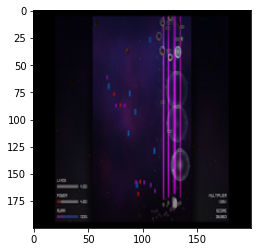

Current step: 20
Best Loss: 23849001287680.0	Current LR: 1	Gradients Average: 1113.98486328125
Predicted Reward: -42702228.0	Current Reward: tensor([[16.8272]], device='cuda:0')
('key', 'Up', 'z')


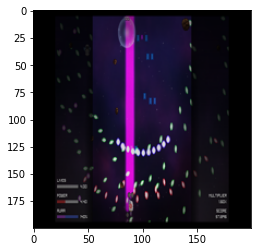

Current step: 30
Best Loss: 23849001287680.0	Current LR: 1	Gradients Average: 4132.5751953125
Predicted Reward: 23661934.0	Current Reward: tensor([[25.8882]], device='cuda:0')
('key', 'Up', 'z')


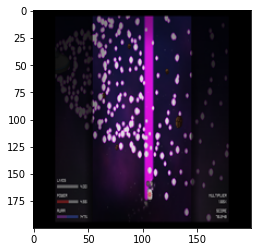

Current step: 40
Best Loss: 23849001287680.0	Current LR: 1	Gradients Average: 5240.9111328125
Predicted Reward: 26509538.0	Current Reward: tensor([[34.1345]], device='cuda:0')
('key', 'Up', 'z')


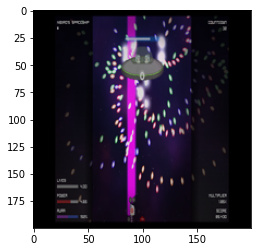

Current step: 50
Best Loss: 23849001287680.0	Current LR: 1	Gradients Average: -4175.15478515625
Predicted Reward: -4949106.5	Current Reward: tensor([[40.5470]], device='cuda:0')
('key', 'Up', 'z')


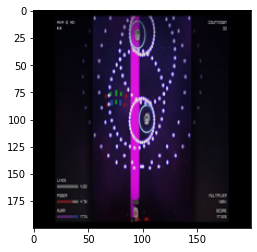

Current step: 60
Best Loss: 23849001287680.0	Current LR: 1	Gradients Average: -4235.884765625
Predicted Reward: -17345400.0	Current Reward: tensor([[49.1145]], device='cuda:0')
('key', 'Up', 'z')


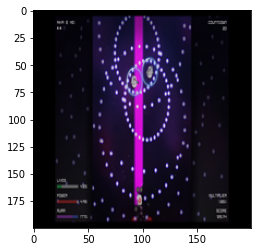

Current step: 70
Best Loss: 23849001287680.0	Current LR: 1	Gradients Average: -3601.916015625
Predicted Reward: -17018848.0	Current Reward: tensor([[57.3665]], device='cuda:0')
('key', 'Up', 'up')


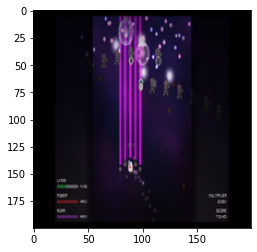

Current step: 80
Best Loss: 23849001287680.0	Current LR: 1	Gradients Average: -4877.0673828125
Predicted Reward: -11749160.0	Current Reward: tensor([[63.9352]], device='cuda:0')
('key', 'Up', 'up')


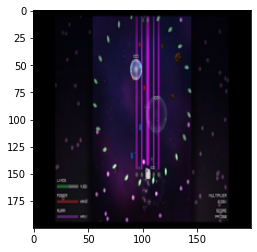

Current step: 90
Best Loss: 15101003300864.0	Current LR: 1	Gradients Average: -5469.87548828125
Predicted Reward: -3914329.0	Current Reward: tensor([[73.3677]], device='cuda:0')
('key', 'Up', 'up')


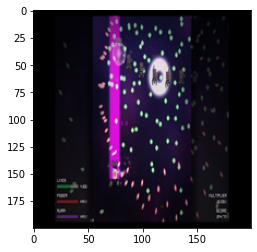

Current step: 100
Best Loss: 4715594645504.0	Current LR: 1	Gradients Average: 346.7174987792969
Predicted Reward: -2171462.25	Current Reward: tensor([[79.7265]], device='cuda:0')
('key', 'Up', 'up')


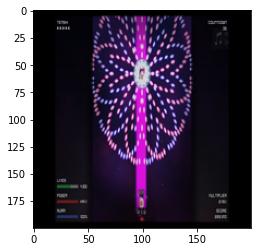

In [25]:
# Playing loop - She learns as she plays
# Jigoku Kisetsukan

reward = torch.zeros((1, 1), device=device) # Cumulative reward
learning_rate = []
grads = []
grad_clip = None
save_path = 'Hakisa'
save_point = 10 # Also optimization point
uncertainty_factor = 0.9 # Also known as gamma or discount factor

encoded_command_type = dataset.encoded_command_type.to(device)
encoded_actions1 = dataset.encoded_actions1.to(device)
encoded_actions2 = dataset.encoded_actions2.to(device)

best_loss = float('inf')

for steps, frames in enumerate(dataloader):

    frames = frames.to(device)

    if steps == 0: # First iteration

        cmds, command_quality, predicted_reward = hakisa(frames)

    else:

        cmd_type = cmds[0][:, command_type.item()].detach()
        act1 = cmds[1][:, action1.item()].detach()
        act2 = cmds[2][:, action2.item()].detach()

        cmds, command_quality, predicted_reward = hakisa(frames, previous_action=(cmd_type, act1, act2), previous_reward=predicted_reward.detach())

    command_type, action1, action2 = torch.argmax(cmds[0], keepdim=True), torch.argmax(cmds[1], keepdim=True), torch.argmax(cmds[2], keepdim=True)

    command = dataset.get_command(command_type.detach().item(), action1.detach().item(), action2.detach().item())

    #hakisa.execute_command(command)

    score = torch.randint(0, 1000000, size=[]).item()

    mult_score = 1.5

    life = 4.00

    power = torch.randint(0, 4, size=[]).item()

    aura = 200

    if life == 0:

        try:
            reward += -(100./(score * mult_score))
        
        except ZeroDivisionError:
            reward += -10.

    else:

        reward += ((score * mult_score) + (power * aura))*1e-6

    del score, mult_score, power, aura, life

    #reward = torch.tensor(reward, device=device)

    if steps == 0:

        previous_command_quality = command_quality.detach()

    action_quality_cost = action_quality_loss(previous_command_quality, command_quality.argmax(1).detach()) # Input = (1, Classes), Target = (1)

    predicted_reward = predicted_reward * uncertainty_factor

    reward_cost = reward_loss(predicted_reward, reward)

    gameplay_loss = action_quality_cost + reward_cost

    gameplay_loss.backward()

    previous_command_quality = command_quality.detach()

    del command_quality

    for n, p in hakisa.named_parameters(): # Checking how the grads and backpropagation are going

            if 'neuron1.weight' in n:
                grads.append(torch.mean(p.grad))

            if grad_clip is not None:
                p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

    if gameplay_loss.item() < best_loss:

        best_loss = gameplay_loss.item()
        best_params = hakisa.state_dict()

    steps += 1

    if steps % save_point == 0:

        optimizer.step()
        scheduler.step()

        hakisa.zero_grad()

        print(f"Current step: {steps}")
        print(f"Best Loss: {best_loss}\tCurrent LR: {scheduler.get_last_lr()[0]}\tGradients Average: {grads[-1]}")
        print(f"Predicted Reward: {predicted_reward.item()}\tCurrent Reward: {reward}")
        print(command)

        visual = frames.view(frames.size(0), frames.size(2), frames.size(3), frames.size(1))
        visual = visual/255
        visual = visual.cpu().numpy()

        plt.imshow(visual[0])
        plt.show()
        

        torch.save({
            'Steps': steps,
            'Hakisa_params': best_params,
            'Hakisa_LR': scheduler.get_last_lr()[0]
        }, f"D:/Python/Projects/Hakisa/Teste/Hakisa_checkpoint.tar")


        winsound.PlaySound(f'D:/Python/Audio/English/chiara_craftEpic_1_en', winsound.SND_FILENAME)